<a href="https://colab.research.google.com/github/theclosedbook/TensorFlow/blob/main/05_Transfer_Learning_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning
In Previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine-Tuning

In [1]:
!nvidia-smi

Thu Feb 22 17:26:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Creating Helper functions

In previous notebooks, we've created a bunch of helper functions.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere).



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-22 17:26:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-22 17:26:53 (82.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

### Let's Get some data

This time we're going to see how we can use the pretrained models within `tf.keras.application` and apply
them to our own problems (recognizing images of food)

In [4]:
# Get 10% of the training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-22 17:26:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.1MB/s    in 8.2s    

2024-02-22 17:27:05 (19.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirecteries are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [6]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.00000000e+01 2.00000000e+00 2.29591817e-01]
   [9.38265324e+00 4.38265276e+00 1.38265300e+00]
   [9.14285755e+00 4.14285755e+00 1.28571439e+00]
   ...
   [1.90943619e+02 1.81515091e+02 1.76300827e+02]
   [1.88658356e+02 1.85137970e+02 1.80469604e+02]
   [2.14219498e+02 2.14760345e+02 2.08989929e+02]]

  [[1.14744911e+01 6.47449112e+00 3.47449064e+00]
   [9.85714340e+00 4.85714340e+00 1.85714340e+00]
   [1.06581631e+01 6.08673429e+00 2.65816259e+00]
   ...
   [1.95719299e+02 1.86290771e+02 1.81474426e+02]
   [1.94459305e+02 1.91602188e+02 1.86602188e+02]
   [2.19571747e+02 2.20571747e+02 2.15571747e+02]]

  [[8.98979568e+00 4.20408154e+00 1.20408154e+00]
   [9.00000000e+00 4.21428585e+00 1.21428585e+00]
   [9.61734676e+00 5.83163261e+00 2.40306091e+00]
   ...
   [1.88494949e+02 1.78494949e+02 1.77663345e+02]
   [1.97372437e+02 1.92459229e+02 1.90015335e+02]
   [1.99775558e+02 1.99132736e+02 1.97132736e+02]]

  ...

  [[1.00000000e+00 3.00000000e+00 0.00000000e+00]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straigh forward, it runs our layers in sequential oreder


In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

24274472/24274472 [==============================] - 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240222-172717
Epoch 1/5
24/24 [==============================] - 18s 246ms/step - loss: 1.8294 - accuracy: 0.4120 - val_loss: 1.2866 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - 4s 150ms/step - loss: 1.1293 - accuracy: 0.7533 - val_loss: 0.8966 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 4s 142ms/step - loss: 0.8387 - accuracy: 0.8147 - val_loss: 0.7112 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 5s 173ms/step - loss: 0.6854 - accuracy: 0.8520 - val_loss: 0.6072 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 3s 129ms/step - loss: 0.5905 - accuracy: 0.8720 - val_loss: 0.5565 - val_accuracy: 0.8569


In [12]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 69ms/step - loss: 0.5672 - accuracy: 0.8572


[0.5672476291656494, 0.857200026512146]

In [13]:
# check the layers in our base model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# Summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# Whole model summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

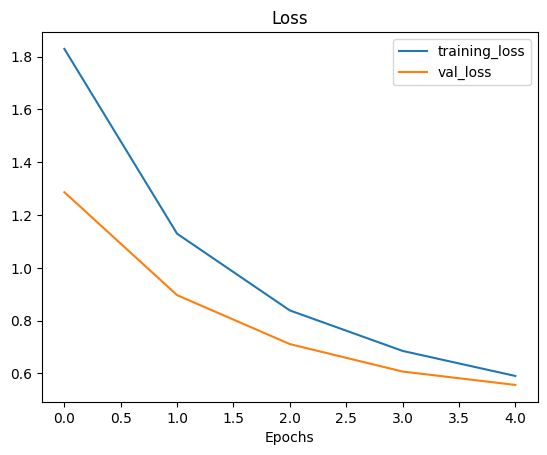

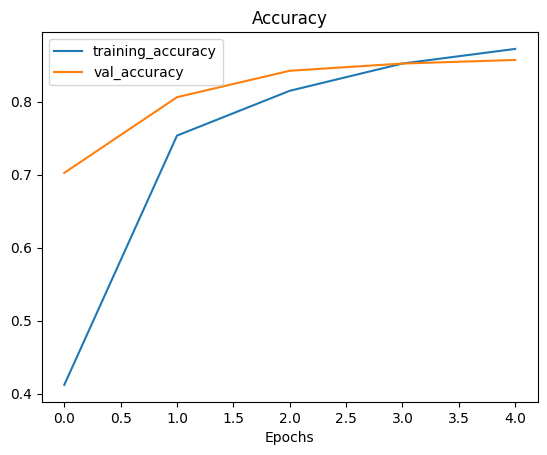

In [16]:
# Check out our models training curves
plot_loss_curves(history_10_percent)

##Getting a feature vector from a trained model

Let's Demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).

Let;s use similar shaped tenspr of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [21]:
# Define Input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"SHape of Global Average Pooled 2D tensor :{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
SHape of Global Average Pooled 2D tensor :(1, 3)
